In [2]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

%run ../scripts/util_func.py
%run ../scripts/model_func.py

In [3]:
# import arrays

icp_states = np.load('../data/icp_states_nojoy.npy', allow_pickle=True) # [time, icp_index, icp_x, icp_y, icp_yaw]
wheel_vels_cmd = np.load('../data/wheel_vels_nojoy.npy', allow_pickle=True) # [time, icp_index, vel_l, vel_r]
wheel_vels_meas = np.load('../data/wheel_vels_meas_nojoy.npy', allow_pickle=True) # [time, icp_index, vel_l, vel_r]
wheel_vels_pwrtrn = np.load('../data/wheel_vels_pwrtrn_nojoy.npy', allow_pickle=True) # [time, icp_index, vel_l, vel_r]

print(wheel_vels_meas)
print(wheel_vels_pwrtrn)

[[0.0 19.0 0.0 0.0]
 [0.051003648000000006 20.0 0.0 0.0]
 [0.097854464 20.0 0.0 0.0]
 ...
 [2157.70171264 21251.0 0.0 0.0]
 [2157.7469585920003 21252.0 0.0 0.0]
 [2157.7972864000003 21252.0 0.0 0.0]]
[[0.00000000e+00 1.90000000e+01 0.00000000e+00 0.00000000e+00]
 [5.10036480e-02 2.00000000e+01 0.00000000e+00 0.00000000e+00]
 [9.78544640e-02 2.00000000e+01 0.00000000e+00 0.00000000e+00]
 ...
 [2.15770171e+03 2.12510000e+04 1.30000000e+01 9.46697425e+00]
 [2.15774696e+03 2.12520000e+04 1.30000000e+01 9.46693002e+00]
 [2.15779729e+03 2.12520000e+04 1.30000000e+01 9.46689593e+00]]


In [27]:
# compute cmd, meas and icp_velocities

r = 0.36
B = 1.296
k = np.array([r, B])

index_vels = np.zeros((int(icp_states[-1, 1]), 1))
cmd_vels = np.zeros((int(icp_states[-1, 1]), 3))
meas_vels = np.zeros((int(icp_states[-1, 1]), 3))
pwrtrn_vels = np.zeros((int(icp_states[-1, 1]), 3))
icp_vels = np.zeros((int(icp_states[-1, 1]), 3))

vel_count = 0
dt = 0.0
vemeasount = 0
cmd_vel_i = np.zeros((1, 3))
meas_vel_i = np.zeros((1, 3))
pwrtrn_vel_i = np.zeros((1, 3))
icp_disp = np.zeros((1, 3))
icp_trav = 0

propa_cos = np.cos(icp_states[0,4])
propa_sin = np.sin(icp_states[0,4])
propa_mat = np.array([[propa_cos, -propa_sin, 0.0], 
                  [propa_sin, propa_cos, 0.0], [0.0, 0.0, 1.0]])

for i in range(icp_states.shape[0] - 1):
    vel_count = vel_count + 1
    cmd_vel_i = cmd_vel_i + diff_drive(wheel_vels_cmd[i, 2:], k)
    meas_vel_i = meas_vel_i + diff_drive(wheel_vels_meas[i, 2:], k)
    pwrtrn_vel_i = pwrtrn_vel_i + diff_drive(wheel_vels_pwrtrn[i, 2:], k)
    
    dt = dt + icp_states[i+1, 0] - icp_states[i, 0]
    
    icp_trav = icp_trav + comp_disp(icp_states[i+1, 2:3], icp_states[i, 2:3])
    
    if icp_states[i+1, 1] != icp_states[i, 1]:
        # filter out icp jumps caused by controller input
        if icp_states[i+1, 0] - icp_states[i, 0] >= 0.5:
            cmd_vels[int(icp_states[i, 1]), :] = np.zeros((1, 3))
            meas_vels[int(icp_states[i, 1]), :] = np.zeros((1, 3))
            pwrtrn_vels[int(icp_states[i, 1]), :] = np.zeros((1, 3))
            icp_vels[int(icp_states[i, 1]), :] = np.zeros((1, 3))
            dt = 0
            vel_count = 0
            cmd_vel_i = np.zeros((1, 3))
            meas_vel_i = np.zeros((1, 3))
            pwr_vel_i = np.zeros((1, 3))
            icp_disp = np.zeros((1, 3))
            icp_trav = 0
    
        else:
            index_vels[int(icp_states[i, 1])] = icp_states[i+1, 0]
            cmd_vels[int(icp_states[i, 1]), :] = cmd_vel_i / vel_count
            meas_vels[int(icp_states[i, 1]), :] = meas_vel_i / vel_count
            pwrtrn_vels[int(icp_states[i, 1]), :] = pwrtrn_vel_i / vel_count
            icp_disp = icp_disp + icp_states[i+1, 2:] - icp_states[i, 2:]
            icp_disp[0,2] = wrap2pi(icp_disp[0,2])

            propa_cos = np.cos(icp_states[i+1,4])
            propa_sin = np.sin(icp_states[i+1,4])
            propa_mat[0,0] = propa_cos
            propa_mat[0,1] = propa_sin
            propa_mat[1,0] = -propa_sin
            propa_mat[1,1] = propa_cos

            icp_disp = propa_mat @ icp_disp.flatten()

            icp_vels[int(icp_states[i, 1]), :] = icp_disp / dt

            dt = 0
            vel_count = 0
            cmd_vel_i = np.zeros((1, 3))
            meas_vel_i = np.zeros((1, 3))
            pwrtrn_vel_i = np.zeros((1, 3))
            icp_disp = np.zeros((1, 3))
            icp_trav = 0
        
cmd_meas_err = cmd_vels - meas_vels
cmd_err = np.linalg.norm(cmd_meas_err, axis=1)
meas_icp_err = meas_vels - icp_vels
icp_err = np.linalg.norm(meas_icp_err, axis=1)
icp_err = np.clip(icp_err, 0.0, 4.0)


In [28]:
print(index_vels.shape)
print(cmd_vels.shape)

print(pwrtrn_vels)
print(meas_vels)

(21252, 1)
(21252, 3)
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 ...
 [ 4.04413123  0.         -0.98127897]
 [ 4.04408918  0.         -0.98134385]
 [ 4.04406001  0.         -0.98138887]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


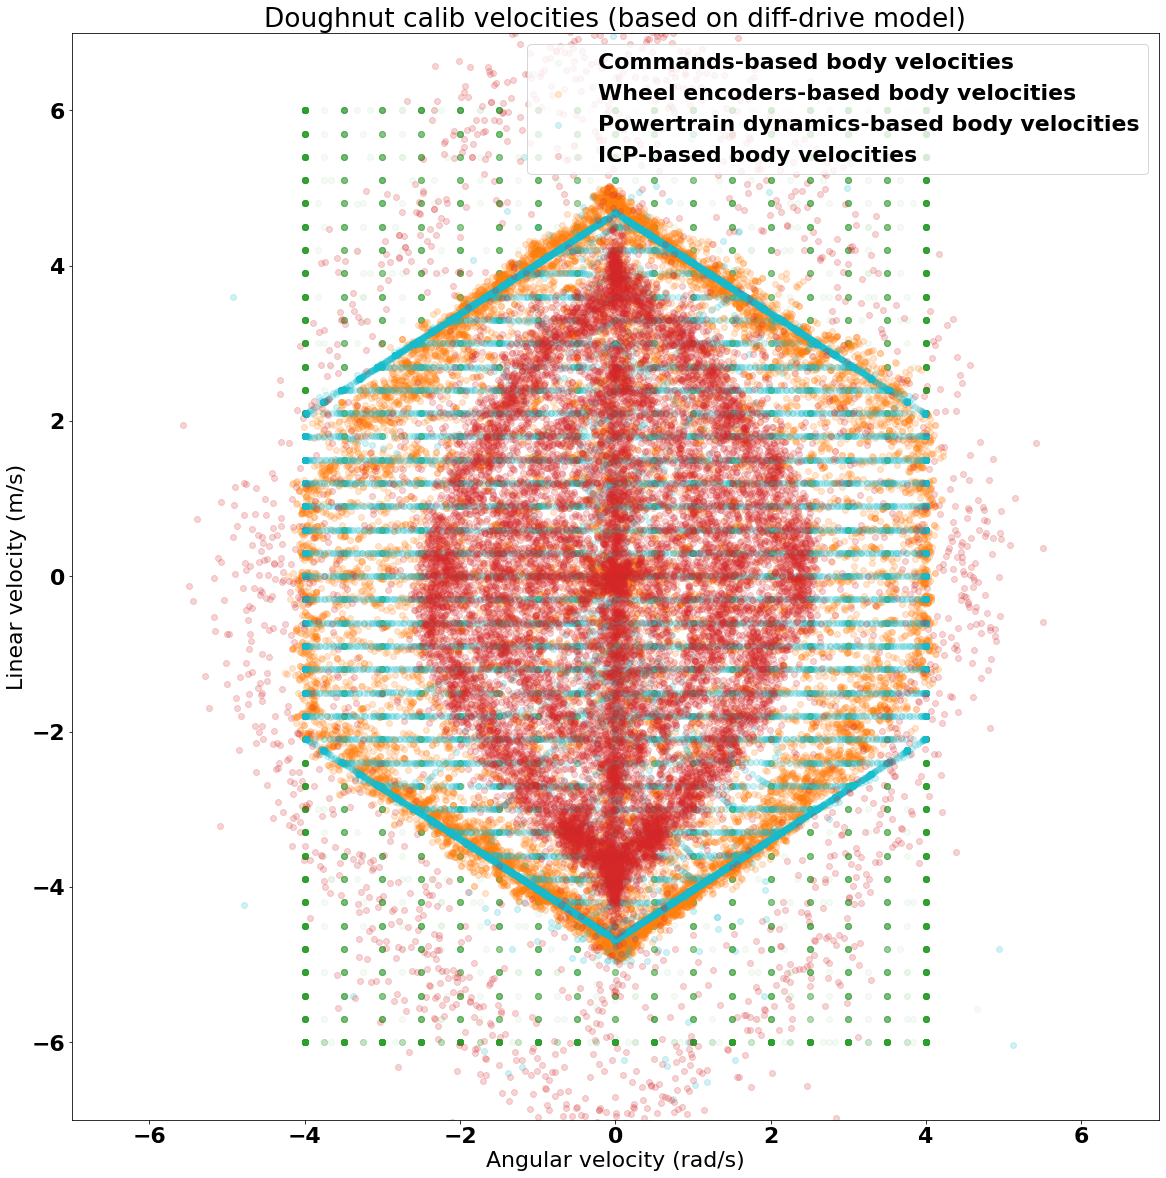

In [29]:
# Plot all velocities

fig, ax = plt.subplots(figsize = (20, 20))

cmd = ax.scatter(cmd_vels[:, 2], cmd_vels[:, 0], c = 'tab:green', alpha = 0.05, label='Commands-based body velocities')
meas = ax.scatter(meas_vels[:, 2], meas_vels[:, 0], c = 'tab:orange', cmap = 'hot', alpha = 0.2, label='Wheel encoders-based body velocities')
pwrtrn = ax.scatter(pwrtrn_vels[:, 2], pwrtrn_vels[:, 0], c = 'tab:cyan', cmap = 'hot', alpha = 0.2, label='Powertrain dynamics-based body velocities')
icp = ax.scatter(icp_vels[:, 2], icp_vels[:, 0], c = 'tab:red', cmap = 'cool', alpha = 0.2, label='ICP-based body velocities')

# X = pwrtrn_vels[:,2]
# Y = pwrtrn_vels[:,0]
# U = icp_vels[:,2] - meas_vels[:,2]
# V = icp_vels[:,0] - meas_vels[:,0]
# quiv = ax.quiver(X, Y, U, V, icp_err, angles='xy', scale_units='xy', scale=1, alpha = 0.1)


ax.set_title('Doughnut calib velocities (based on diff-drive model)')
ax.set_ylabel('Linear velocity (m/s)')
ax.set_xlabel('Angular velocity (rad/s)')
# ax.axis('equal')
xmin = ymin = -7
xmax = ymax = 7
ax.axis([xmin, xmax, ymin, ymax])
ax.set_aspect('equal', adjustable='box')
leg = ax.legend(loc='upper right')
leg.set_alpha(1)

# ax.set_xlim([-7.5, 7.5])
# ax.set_ylim([-7.5, 7.5])
# ax.axis('equal')

# cb_enc = fig.colorbar(meas,fraction=0.04, pad=0.04)
# cb_enc.set_alpha(1)
# cb_enc.set_ticks([])
# cb_enc.set_label('Encoders-based body velocities')
# cb_enc.draw_all()

# cb_icp = fig.colorbar(icp,fraction=0.045, pad=0.04)
# cb_icp.set_alpha(1)
# cb_icp.set_ticks([])
# cb_icp.set_label('ICP-based body velocities')
# cb_icp.draw_all()

# cb_icp = fig.colorbar(quiv,fraction=0.045, pad=0.04)
# cb_icp.set_alpha(1)
# cb_icp.set_ticks([])
# cb_icp.set_label('encoder to ICP body velocities error')
# cb_icp.draw_all()

plt.show()

fig.savefig('dougnhut_calib_vels.png')

# fig.tight_layout()

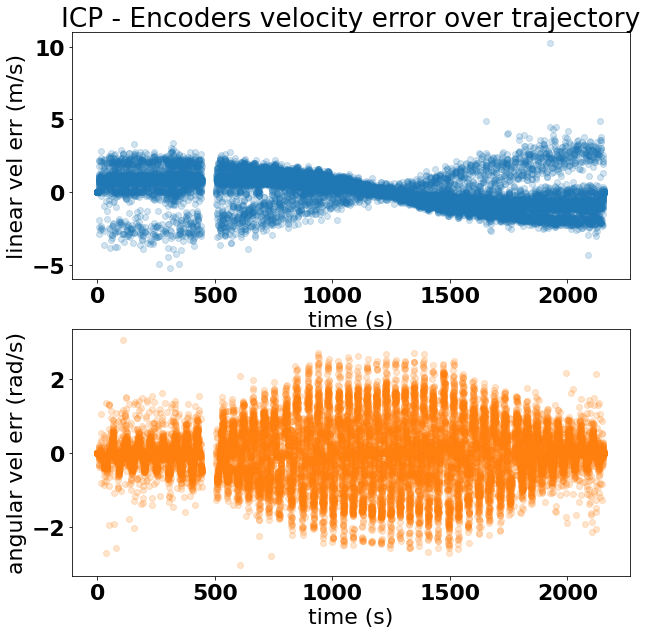

In [30]:
# Compute and plot icp - encoders error

vel_errors = np.zeros((index_vels.shape[0], 3))

for i in range(index_vels.shape[0]):
    vel_errors[i,:] = icp_vels[i, :] - meas_vels[i, :]
    vel_errors[i, 2] = wrap2pi(vel_errors[i, 2])

fig, axs = plt.subplots(2, figsize = (10, 10))

axs[0].scatter(index_vels[:, 0], vel_errors[:, 0], alpha = 0.2)
axs[1].scatter(index_vels[:, 0], vel_errors[:, 2], c = 'tab:orange', alpha = 0.2)
axs[0].set_title('ICP - Encoders velocity error over trajectory')
for ax in axs:
    ax.set_xlabel('time (s)')
axs[0].set_ylabel('linear vel err (m/s)')
axs[1].set_ylabel('angular vel err (rad/s)')

fig.savefig('dougnhut_calib_vl_errs.png')

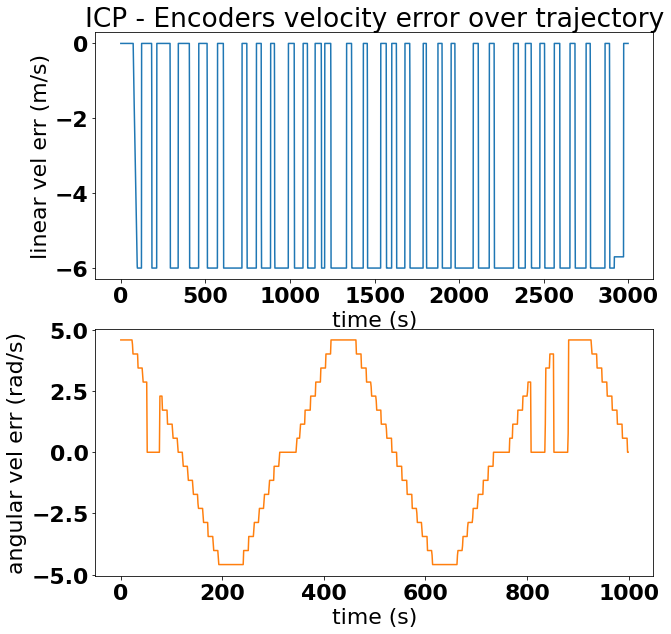

In [26]:
# Compute command-based linear and angular vels only to check limits

fig, axs = plt.subplots(2, figsize = (10, 10))

axs[0].plot(cmd_vels[0:3000, 0])
axs[1].plot(cmd_vels[6000:7000, 2], c = 'tab:orange')
axs[0].set_title('ICP - Encoders velocity error over trajectory')
for ax in axs:
    ax.set_xlabel('time (s)')
axs[0].set_ylabel('linear vel err (m/s)')
axs[1].set_ylabel('angular vel err (rad/s)')

fig.savefig('dougnhut_calib_vl_errs.png')